<a href="https://colab.research.google.com/github/Devarsh-Patel/CECS-456-Machine-Learning-Project/blob/main/animals_szeman_tang.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [25]:
! pip install kaggle

In [ ]:
! mkdir ~/.kaggle

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [ ]:
! cp kaggle.json ~/.kaggle/

In [ ]:
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
! kaggle datasets download -d alessiocorrado99/animals10

animals10.zip: Skipping, found more recently modified local copy (use --force to force download)


In [ ]:
#!unzip animals10.zip

In [26]:
import tensorflow as tf
import tensorflow_datasets as tfds
import sklearn
import numpy as np
import pandas as pd
import tensorflow as tf

np.random.seed(42)
import matplotlib as mpl
import matplotlib.pyplot as plt
import os
import cv2

from tensorflow.keras import layers
from tensorflow.keras import regularizers

from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from keras.regularizers import l2


from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator

In [24]:
batch_size = 64
img_height = 227
img_width = 227

In [29]:
#Load data using a Keras utility
train_ds = tf.keras.utils.image_dataset_from_directory(
  'raw-img',
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 26179 files belonging to 10 classes.
Using 20944 files for training.


In [30]:
# add a testing
val_ds = tf.keras.utils.image_dataset_from_directory(
 'raw-img',
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 26179 files belonging to 10 classes.
Using 5235 files for validation.


In [31]:
class_names = train_ds.class_names
print(class_names)

['cane', 'cavallo', 'elefante', 'farfalla', 'gallina', 'gatto', 'mucca', 'pecora', 'ragno', 'scoiattolo']


In [35]:
normalization_layer = tf.keras.layers.Rescaling(1./255)

In [34]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(64, 227, 227, 3)
(64,)


In [36]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Pixel values are now in [0,1]
print(np.min(first_image), np.max(first_image))

0.0 0.9995644


In [37]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [38]:
alexnet = tf.keras.models.Sequential()

alexnet.add(tf.keras.layers.Conv2D(filters=96, kernel_size=(11,11), strides=(4,4), activation='relu', input_shape=(227,227,3)))
alexnet.add(tf.keras.layers.BatchNormalization())
alexnet.add(tf.keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2)))

alexnet.add(tf.keras.layers.Conv2D(filters=256, kernel_size=(5,5), strides=(1,1), activation='relu', padding="same"))
alexnet.add(tf.keras.layers.BatchNormalization())
alexnet.add(tf.keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2)))

alexnet.add(tf.keras.layers.Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same"))
alexnet.add(tf.keras.layers.BatchNormalization())

alexnet.add(tf.keras.layers.Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same"))
alexnet.add(tf.keras.layers.BatchNormalization())

alexnet.add(tf.keras.layers.Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same"))
alexnet.add(tf.keras.layers.BatchNormalization())
alexnet.add(tf.keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2)))

alexnet.add(tf.keras.layers.Flatten())
alexnet.add(tf.keras.layers.Dense(4096, activation='relu'))
alexnet.add(tf.keras.layers.Dropout(0.5))

alexnet.add(tf.keras.layers.Dense(4096, activation='relu'))
alexnet.add(tf.keras.layers.Dropout(0.5))

alexnet.add(tf.keras.layers.Dense(10, activation='softmax'))

In [40]:
opt = tf.keras.optimizers.Adam(0.001)

alexnet.compile(
  optimizer=opt,
  loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])

In [41]:
 alexnet.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_10 (Conv2D)          (None, 55, 55, 96)        34944     
                                                                 
 batch_normalization_10 (Bat  (None, 55, 55, 96)       384       
 chNormalization)                                                
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 27, 27, 96)       0         
 2D)                                                             
                                                                 
 conv2d_11 (Conv2D)          (None, 27, 27, 256)       614656    
                                                                 
 batch_normalization_11 (Bat  (None, 27, 27, 256)      1024      
 chNormalization)                                                
                                                      

In [45]:
history = alexnet.fit(train_ds, validation_data=val_ds, batch_size = 64, epochs=20)

Epoch 1/20
328/328 [==============================] - 29s 88ms/step - loss: 1.7679 - accuracy: 0.3997 - val_loss: 1.6567 - val_accuracy: 0.4344
Epoch 2/20
328/328 [==============================] - 29s 88ms/step - loss: 1.6428 - accuracy: 0.4460 - val_loss: 1.9507 - val_accuracy: 0.3142
Epoch 3/20
328/328 [==============================] - 29s 88ms/step - loss: 1.5515 - accuracy: 0.4837 - val_loss: 1.8733 - val_accuracy: 0.3379
Epoch 4/20
328/328 [==============================] - 29s 89ms/step - loss: 1.4455 - accuracy: 0.5212 - val_loss: 2.3793 - val_accuracy: 0.3087
Epoch 5/20
328/328 [==============================] - 29s 88ms/step - loss: 1.3654 - accuracy: 0.5510 - val_loss: 1.7684 - val_accuracy: 0.4078
Epoch 6/20
328/328 [==============================] - 29s 88ms/step - loss: 1.2992 - accuracy: 0.5777 - val_loss: 1.6866 - val_accuracy: 0.4441
Epoch 7/20
328/328 [==============================] - 29s 89ms/step - loss: 1.2379 - accuracy: 0.6000 - val_loss: 2.1085 - val_accuracy:

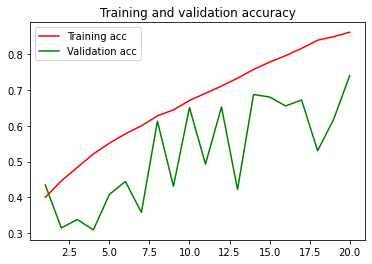

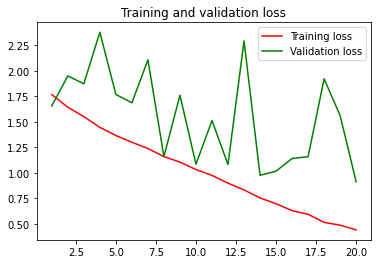

In [47]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'red', label='Training acc')
plt.plot(epochs, val_acc, 'green', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'red', label='Training loss')
plt.plot(epochs, val_loss, 'green', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()